In [76]:
import json

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex

import pandas as pd
import numpy as np
import umap
from openai import OpenAI
import warnings

# Suppress all UserWarnings because umap is annoying
warnings.filterwarnings("ignore", category=UserWarning)

In [77]:
df = pd.read_csv('race_names.csv')
df.sample(10)

,first_name,last_name,race5,frequency
20473,LISA,BROOKS,White,31
1457,ANDREW,LAMBERT,White,12
12493,JAMES,LONG,Other,18
1598,ANGEL,JONES,Black,29
19886,LAURA,CARLSON,White,13
17025,JOSHUA,ELLIS,White,31
20753,LISA,WALTERS,White,19
276,ALAN,ROBERTS,White,12
20876,LORI,MORGAN,White,18
21873,MARY,WOODS,White,12


Split the dataset to get random samples for training and testing, but only allow a last name to appear once.

In [78]:


# Define the proportion for the training set
train_proportion = 0.40
test_proportion = 0.40 

# Get unique last names to ensure they are exclusive between training and test sets
unique_last_names = df['last_name'].unique()

# Shuffle the unique last names to randomize the order
np.random.shuffle(unique_last_names)

# Calculate the number of unique last names to include in each set
num_train = int(np.floor(train_proportion * len(unique_last_names)))
num_test = int(np.floor(test_proportion * len(unique_last_names)))

# Split the unique last names into training and testing sets
train_last_names = unique_last_names[:num_train]
test_last_names = unique_last_names[num_train:num_train + num_test]

# Remaining last names for a possible validation set or to be unused
unused_last_names = unique_last_names[num_train + num_test:]

# Create masks for the training and testing sets
train_mask = df['last_name'].isin(train_last_names)
test_mask = df['last_name'].isin(test_last_names)

# Now that we have the last names for each set, we can sample the first names weighted by frequency
# For the training set
train_sample = df[train_mask].sample(n=3000, weights=train_mask.astype(int) * df['frequency'], replace=False)
train_sample['sample'] = 'Train'
# For the test set, we ensure no last names from the training set are included
test_sample = df[test_mask].sample(n=3000, weights=test_mask.astype(int) * df['frequency'], replace=False)
test_sample['sample'] = 'Test'

df_sample = pd.concat([train_sample,test_sample])

In [79]:
df.groupby('race5')['last_name'].count()

race5
Asian                   147
Black                  5259
Hispanic or Latino      574
Other                  1340
White                 26240
Name: last_name, dtype: int64

In [80]:
df_sample['name'] = df_sample['first_name'] + ' ' + df_sample['last_name']
df_sample["name"] = df_sample["name"].str.title()

Next, I get the embeddings for the three models of interest. `text-embedding-ada-002` and `text-embedding-3-small` but represent texts in 1,536 dimensions, while `text-embedding-3-large` has twice as many. This is hard to plot, so, following the good folks at Bloomberg, I use UMAP to reduce this down to just two dimensions for each embedding model. I also tried a different algorithm, TSNE with very similar results. 

In [81]:
import openai

def get_open_embeddings(text_list, model="text-embedding-3-small"):
    client = openai.Client(max_retries=3)
    
    def chunker(seq, size):
        """Helper function to split sequences into chunks"""
        return (seq[pos:pos + size] for pos in range(0, len(seq), size))
    
    embeddings = []
    
    # Split the text_list into chunks of 1000
    for text_chunk in chunker(text_list, 1000):
        # Fetch embeddings for the current chunk
        embeddings_response = client.embeddings.create(input=text_chunk, model=model)
        
        # Extend our embeddings list with the new results
        embeddings.extend([text.embedding for text in embeddings_response.data])
    
    return embeddings

model = "text-embedding-3-small"
if model not in df_sample.keys():
    names = df_sample["name"].tolist()
    df_sample[model] = get_open_embeddings(names, model=model)
        

In [82]:
def reduce_dimensions(
    df, embedding_column, n_components=2, random_state=42, n_neighbors=30, min_dist=0.9
):
    """Reduces the dimensions of embeddings to 2D using UMAP."""
    embeddings = np.vstack(df[embedding_column])
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    df[f"{embedding_column}_umap_x"], df[f"{embedding_column}_umap_y"] = (
        reduced_embeddings.T
    )
    return df


# Main code
df_sample = reduce_dimensions(df_sample, model)

Finally, plot them. I added gender to the mix by showing women's names with a darker hue.

In [83]:


# Base colors for races
race2color = {
    "White": "#c71e1d",
    "Black": "#fa8c00",
    "Asian": "#009076",
    "Hispanic or Latino": "#15607a",
    "Other": "grey",
}

def plot_names(name_df = 'df', model='text-embedding-3-small'):
    # Extend race2color with darker shades for females
    race2color_female = {race: darken_color(color) for race, color in race2color.items()}

    # Extract UMAP coordinates, names, races, and sexes
    umap_x = name_df[f"{model}_umap_x"].values
    umap_y = name_df[f"{model}_umap_y"].values
    races = name_df["race5"].values
    #sexes = name_df["sex"].values

    # Determine color based on race and sex
    colors = [
        race2color[race] for race in races
    ]

    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.scatter(umap_x, umap_y, color=colors, alpha=0.5)

    # Enhancements
    ax.set_title(f"UMAP projection of {model} Embeddings by Race", fontsize=16)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

    # Optional: Remove the x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

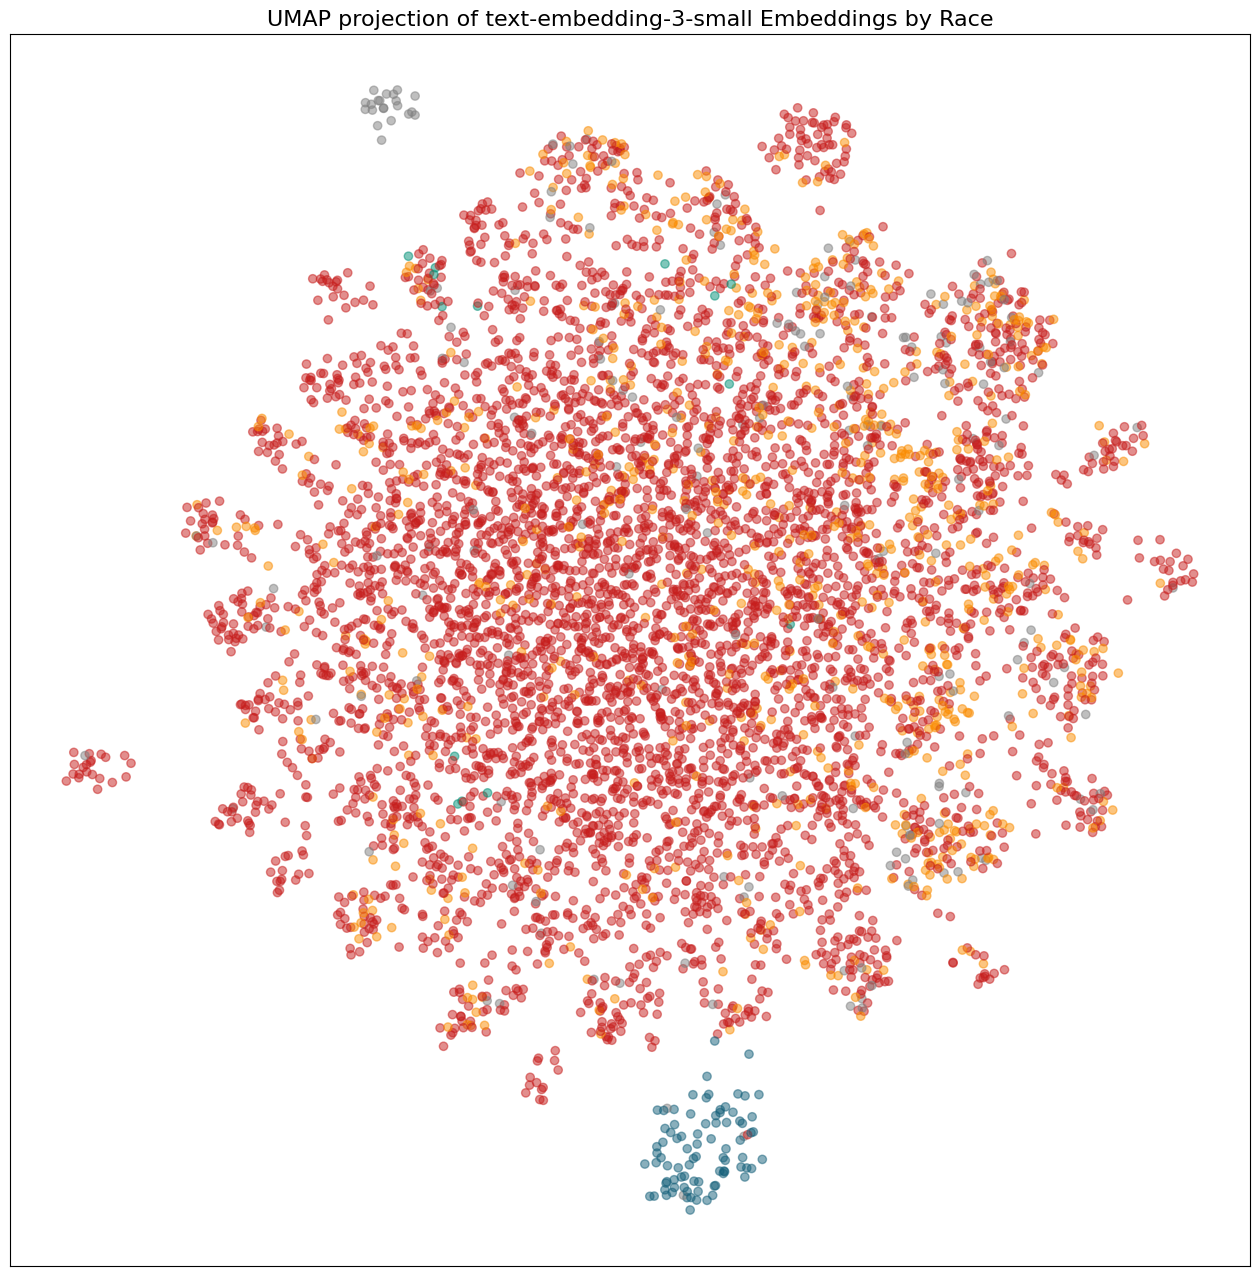

In [84]:
plot_names(df_sample, model)

Back when I thought it would be useful, I also tried to model how many embedding dimensions it would take, leveraging the fact that the two new OpenAI models apparently put all the interesting ones up from. Results do seem to confirm that, but again, with only 20 last names, I don't make too much of this.

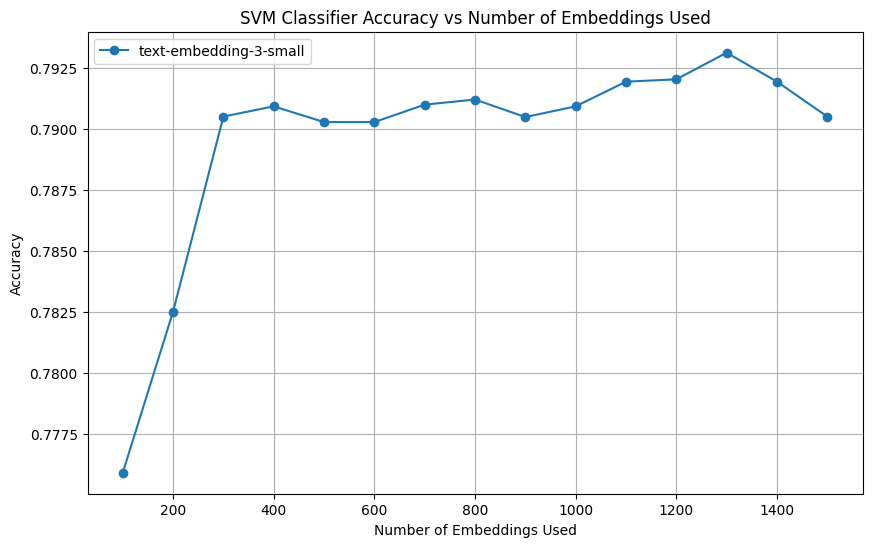

In [89]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'name_df' is your DataFrame and it includes both the embedding feature
# 'text-embedding-3-small' and the 'race' column.

# Updated function to use a dataframe with a 'sample' column to determine train/test sets
def train_and_evaluate_svm(df, embeddings_column, target_column, max_columns):
    # Initialize list to store accuracy scores
    accuracies = []
    columns_used = []
    
    # Separate the dataframe into training and testing based on the 'sample' column
    train_df = df[df['sample'] == 'Train']
    test_df = df[df['sample'] == 'Test']
    
    for num_embeddings in range(100, max_columns + 1, 100):
        # Extract the first 'num_embeddings' from each row in the embeddings column for both training and testing
        X_train = np.array(train_df[embeddings_column].apply(lambda x: x[:num_embeddings]).tolist())
        y_train = train_df[target_column].values
        
        X_test = np.array(test_df[embeddings_column].apply(lambda x: x[:num_embeddings]).tolist())
        y_test = test_df[target_column].values
        
        # Initialize and train the SVM classifier
        clf = SVC(kernel='rbf', C=1.0, random_state=42)
        clf.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = clf.predict(X_test)
        
        # Calculate and store the accuracy
        accuracy = f1_score(y_test, y_pred, average='weighted') 
        accuracies.append(accuracy)
        columns_used.append(num_embeddings)
    
    return accuracies, columns_used
# Assuming 'text-embedding-3-small' contains embeddings and 'race' is the target column
# Also assuming each embedding in 'text-embedding-3-small' has at least 200 dimensions
plt.figure(figsize=(10, 6))

colors = ['b', 'g', 'r']  # Define a list of colors if you want specific colors for each model
model_names = ['text-embedding-3-small',]
# Alternatively, remove the colors list and Matplotlib will automatically assign colors.

for i, model in enumerate(model_names):
    accuracies, columns_used = train_and_evaluate_svm(df_sample, model, 'race5', 1500)

    # Plotting the accuracy vs. number of embeddings used
    # If using automatic colors, just remove the color argument
    plt.plot(columns_used, accuracies, marker='o', linestyle='-', label=model)

plt.title('SVM Classifier Accuracy vs Number of Embeddings Used')
plt.xlabel('Number of Embeddings Used')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()  # This adds the legend using the labels specified in plt.plot()
plt.show()